# Implementation of neural ODE on classification of basic singular images (with one shape in them : circle, rectangle, triangle) and compound images.

In [222]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import time

import math
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from IPython import display
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import imageio
import numpy as np

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Euler ODE solve method

Typically used as simplest implementation, however any explicit or implicit method will do.

In [ ]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

"

We also implement a superclass of parameterized dynamics function in the form of neural network with a couple useful methods.

First, one needs to be able to flatten all the parameters that the function depends on.

Second, one needs to implement a method that computes the augmented dynamics. This augmented dynamics depends on the gradient of the function wrt. its inputs and parameters. In order to not have to specify them by hand for every new architecture, we will use torch.autograd.grad method.
"

In [ ]:


class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)





"The code below incapsulates forward and backward passes of Neural ODE. We have to separate it from main torch.nn.Module because custom backward function can't be implemented inside Module, but can be implemented inside torch.autograd.Function. So this is just a little workaround.

This function underlies the whole Neural ODE method."


This adjoint class below is a direct attempt to calculate gradient of loss wrt to hidden states. From there, we will be calculating the loss gradient wrt model parameters.

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Wrapper ODE adjoint method 

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [ ]:


def to_np(x):
    return x.detach().cpu().numpy()



### Linear ODE

In [ ]:


class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)



In [ ]:


class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))



class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)



In [ ]:


def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()



def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"assets/imgs/{name}/{i}.png")
            clear_output(wait=True)



FileNotFoundError: ignored

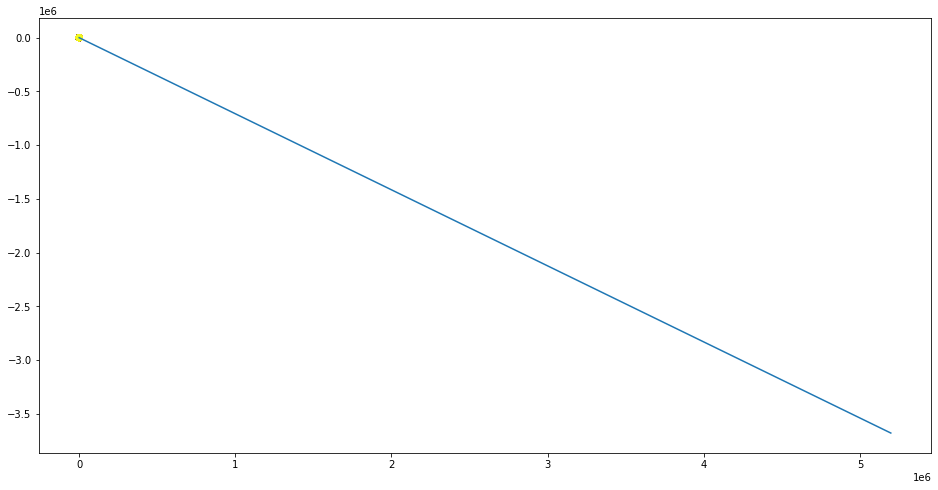

In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

conduct_experiment(ode_true, ode_trained, 500, "linear")

In [ ]:
import os
os.chdir("/content/drive/")
!ls

# Implementation on ShapeDataset

The above so far is taken from the neural ODE paper that this study is analysing. From here on out, the code below has been developed and modified to be used for classification of shapes of which we have yet to find online directly.

The conceptualization of attempting to use neural ODEs for standard image classification has been discussed, but not necessarily encouraged. Here, we are going to give that a try, together with a number of adjustments to the ode_solve algorithm.

In [ ]:


def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)



In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

## Numpy Array shape dataset

Let's try this neural ODEnetwork on our set of 3 shapes!

In [223]:
import cv2
import random
import PIL
from PIL import Image
from IPython import display
from __future__ import print_function, division
import os
from typing import TypeVar, Generic, Iterable, Iterator, Sequence, List, Optional, Tuple
import torch
import pandas as pd
from torchvision.transforms import ToTensor
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from natsort import natsorted

In [224]:
import bisect
import warnings

from torch._utils import _accumulate
from torch import randperm
# No 'default_generator' in torch/__init__.pyi
from torch import default_generator, Tensor  # type: ignore
from typing import TypeVar, Generic, Iterable, Iterator, Sequence, List, Optional, Tuple
# from ... import Tensor, Generator

### Shape generating dataset

In [225]:
# config values
NUM_OF_DATA = 1000

WIDTH = 28
HEIGHT = 28  #The above 3 will be used throughout

WHITE = (255,255,255)
BLACK = (0,0,0)

MIN_THICKNESS = 1
MAX_THICKNESS = 1
###

CENTER_X = WIDTH //2
CENTER_Y = HEIGHT//2

In [226]:
def shapeset(NUM):
  tri = []
  Vary = random.random()*2.+2.  #Vary the size of the shapes
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255


  #triangles
      t_height = Vary*HEIGHT//5
      t_width  =  Vary*WIDTH //5
      t_dir    = np.random.choice([1,-1])  #This sets the triangle to be right ways up or upside down (-1)
      #Random center
      x_bias = random.randint(t_width - WIDTH, WIDTH - t_width)//2
      y_bias = random.randint(t_height - HEIGHT, HEIGHT - t_height)//2

      t_thickness = np.int32(1)

      vertices = np.array([
          [CENTER_X + x_bias, CENTER_Y + t_height//2 * t_dir + y_bias],
          [CENTER_X - t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias],
          [CENTER_X + t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias]
      ])
      pts = vertices.reshape((-1, 1, 2))
      cv2.polylines(img,np.int32([pts]), isClosed = True, color = BLACK, thickness = t_thickness)
      # tri.append([img,[1,0,0]])
      tri.append([img, np.int(1)]) #label to indicate shape
  rect = []
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

  #rectangles
      r_height = (random.random()*.7+.25)*Vary*HEIGHT//5
      r_width  = Vary*WIDTH //5

      #Random center
      x_bias = random.randint(r_width - WIDTH, WIDTH - r_width)//2
      y_bias = random.randint(r_height - HEIGHT, HEIGHT - r_height)//2

      r_thickness = np.int32(1)

      vertices = np.array([
          [CENTER_X + r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
          [CENTER_X - r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
          [CENTER_X - r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias],
          [CENTER_X + r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias]
      ])
      pts = vertices.reshape((-1, 1, 2))
      cv2.polylines(img, np.int32([pts]), isClosed = True, color = BLACK, thickness = r_thickness)

      rect.append([img, np.int(2)])
      # rect.append([img,[0,1,0]])
  circ = []
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

  #circles
      c_rad = random.randint(4,13)

      c_thickness = random.randint(MIN_THICKNESS, MAX_THICKNESS)/2

      x_bias = random.randint(c_rad * 2 - WIDTH, WIDTH - c_rad * 2)//2
      y_bias = random.randint(c_rad * 2 - HEIGHT, HEIGHT - c_rad * 2)//2

      cv2.circle(img,
          center = (CENTER_X + x_bias, CENTER_Y + y_bias),
          radius = c_rad,
          color = BLACK,
          thickness = r_thickness
      )

      circ.append([img,np.int(0)])
      # circ.append([img,[0,0,1]])

  tot_data = []
  for t in tri: tot_data.append([cv2.cvtColor(t[0],cv2.COLOR_BGR2GRAY),t[1]])
  for r in rect: tot_data.append([cv2.cvtColor(r[0],cv2.COLOR_BGR2GRAY),r[1]])
  for c in circ: tot_data.append([cv2.cvtColor(c[0],cv2.COLOR_BGR2GRAY),c[1]])
  random.shuffle(tot_data)

  data_x = []
  data_y = []
  for d in tot_data:
      data_x.append(d[0])
      data_y.append(d[1])

  return [data_x, data_y]

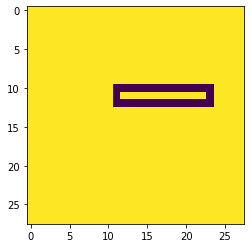

In [ ]:
plt.imshow(shapeset(1)[0][0])

## Shapedataset with blank images

This will be used later in our multiple images classification implementation

In [227]:
def shapeset2(NUM):
  tri = []
  Vary = random.random()*2.+2.  #Vary the size of the shapes
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255


  #triangles
      t_height = Vary*HEIGHT//5
      t_width  =  Vary*WIDTH //5
      t_dir    = np.random.choice([1,-1])  #This sets the triangle to be right ways up or upside down (-1)
      #Random center
      x_bias = random.randint(t_width - WIDTH, WIDTH - t_width)//2
      y_bias = random.randint(t_height - HEIGHT, HEIGHT - t_height)//2

      t_thickness = np.int32(1)

      vertices = np.array([
          [CENTER_X + x_bias, CENTER_Y + t_height//2 * t_dir + y_bias],
          [CENTER_X - t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias],
          [CENTER_X + t_width//2 + x_bias, CENTER_Y - t_height//2 * t_dir + y_bias]
      ])
      pts = vertices.reshape((-1, 1, 2))
      cv2.polylines(img,np.int32([pts]), isClosed = True, color = BLACK, thickness = t_thickness)
      # tri.append([img,[1,0,0]])
      tri.append([img, np.int(2)]) #label to indicate shape
      # tri.append([img, 'triangle ']) #label to indicate shape
  
  
  
  rect = []
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

  #rectangles
      r_height = (random.random()*.7+.25)*Vary*HEIGHT//5
      r_width  = Vary*WIDTH //5

      #Random center
      x_bias = random.randint(r_width - WIDTH, WIDTH - r_width)//2
      y_bias = random.randint(r_height - HEIGHT, HEIGHT - r_height)//2

      r_thickness = np.int32(1)

      vertices = np.array([
          [CENTER_X + r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
          [CENTER_X - r_width//2 + x_bias, CENTER_Y + r_height//2 + y_bias],
          [CENTER_X - r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias],
          [CENTER_X + r_width//2 + x_bias, CENTER_Y - r_height//2 + y_bias]
      ])
      pts = vertices.reshape((-1, 1, 2))
      cv2.polylines(img, np.int32([pts]), isClosed = True, color = BLACK, thickness = r_thickness)
      # rect.append([img, 'rectangle '])
      rect.append([img, np.int(3)])
      # rect.append([img,[0,1,0]])
  
  
  
  
  circ = []
  for _ in range(NUM):
      img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255

  #circles
      c_rad = random.randint(4,13)

      c_thickness = random.randint(MIN_THICKNESS, MAX_THICKNESS)/2

      x_bias = random.randint(c_rad * 2 - WIDTH, WIDTH - c_rad * 2)//2
      y_bias = random.randint(c_rad * 2 - HEIGHT, HEIGHT - c_rad * 2)//2

      cv2.circle(img,
          center = (CENTER_X + x_bias, CENTER_Y + y_bias),
          radius = c_rad,
          color = BLACK,
          thickness = r_thickness
      )
      # circ.append([img,'circle '])
      circ.append([img,np.int(1)])
      # circ.append([img,[0,0,1]])


  blank = []
  for _ in range(NUM):
    img = np.zeros((WIDTH, HEIGHT, 3), np.uint8) + 255
    blank.append([img, np.int(0)])


  tot_data = []
  for t in tri: tot_data.append([cv2.cvtColor(t[0],cv2.COLOR_BGR2GRAY),t[1]])
  for r in rect: tot_data.append([cv2.cvtColor(r[0],cv2.COLOR_BGR2GRAY),r[1]])
  for c in circ: tot_data.append([cv2.cvtColor(c[0],cv2.COLOR_BGR2GRAY),c[1]])
  for thing in blank : tot_data.append([cv2.cvtColor(thing[0],cv2.COLOR_BGR2GRAY),thing[1]])
  random.shuffle(tot_data)

  data_x = []
  data_y = []
  for d in tot_data:
      data_x.append(d[0])
      data_y.append(d[1])

  return [data_x[:NUM], data_y[:NUM]]

In [ ]:

def RES(thing):
  return np.array(thing).reshape(28,28)

[0]


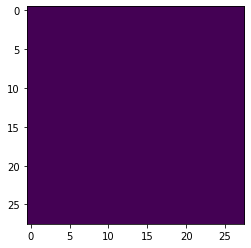

In [ ]:

datum = shapeset2(1)
print(datum[1])


plt.imshow(RES(datum[0]))

## Neural Shape classifier

In [ ]:
class ContinuousNeural3Classifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeural3Classifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeural3Classifier(ode)
if use_cuda:
    model = model.cuda()


In [ ]:


class TensorDataset(Dataset):
    def __init__(self, xyfile ):
        self.xfile, self.yfile = xyfile
    def __len__(self):
        return len(self.yfile)

    def __getitem__(self, index):
        # img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # image = torchvision.transforms.functional.to_tensor(self.xfile[index].reshape( 1, 28, 28))
        image = torchvision.transforms.functional.to_tensor(self.xfile[index])
        y_label = torch.tensor(self.yfile[index])

        return (image, y_label)        

In [ ]:
train_dataset = TensorDataset(shapeset(900)) 
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
print(train_dataset.__dict__.keys())

dict_keys(['xfile', 'yfile'])


In [ ]:
test_dataset = TensorDataset(shapeset(2000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
print(train_dataset.__dict__.keys())

dict_keys(['xfile', 'yfile'])


In [ ]:
# batch_size = 32
# train_loader = torch.utils.data.DataLoader(
#     shapeset(1000),
#     batch_size=batch_size, shuffle=True
# )

# test_loader = torch.utils.data.DataLoader(
#     shapeset(2000),
#     batch_size=128, shuffle=True
# )
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.333%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.20412
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%
Training Epoch 2...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.01567
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%
Training Epoch 3...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00618
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%
Training Epoch 4...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00367
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%
Training Epoch 5...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00218
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%


<Figure size 648x360 with 0 Axes>

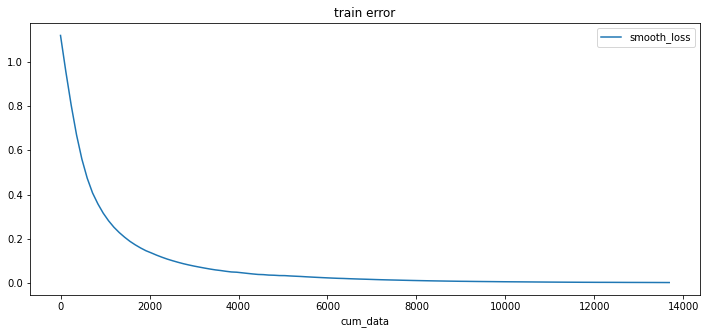

In [ ]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * 120
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

# Backward Euler Implementation

In [ ]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z+h, t+h)#Backwards euler implementation
        t = t + h
    return z

In [ ]:
class ContinuousNeural3Classifier_Backward(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeural3Classifier_Backward, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 3) 

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

We also need to rerun the adjoint method to ensure it uses the new ode_solve method

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model_back.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_back(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_back.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_back(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]


class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)



In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_back = ContinuousNeural3Classifier_Backward(ode)
if use_cuda:
    model_back = model_back.cuda()

train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_back.parameters())

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.333%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.18350
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 66.150%
Training Epoch 2...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.01623
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 95.067%
Training Epoch 3...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00631
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%
Training Epoch 4...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00403
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%
Training Epoch 5...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00281
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 100.000%


<Figure size 648x360 with 0 Axes>

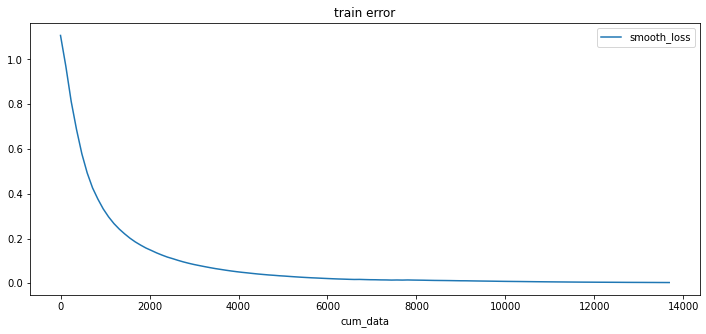

In [ ]:
  import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * 120
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

#Crank Nicolson Implementation

Crank Nicolson implementation is simply the Euler approximation implemented with the gradient function f being evaluated at the middle of the step.

In [ ]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z+h/2, t+h/2)#Backwards euler implementation
        t = t + h
    return z

In [ ]:
class ContinuousNeural3Classifier_C(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeural3Classifier_C, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 3) 

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model_c.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_c(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_c.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_c(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]


class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)



In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_c = ContinuousNeural3Classifier_C(ode)
if use_cuda:
    model_c = model_c.cuda()

train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_c.parameters())

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.333%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.19759
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 65.933%
Training Epoch 2...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.01488
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 90.717%
Training Epoch 3...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00642
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 94.283%
Training Epoch 4...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00420
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 94.067%
Training Epoch 5...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.00657
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 91.650%


#Multiple Shapes

Remake the shape generating function with vector output to allow us to indicate multiple shape occurrences.

Define the functions necessary to coaelesce 2 images of different types together.

In [ ]:
def theimagesareofthesametype(data, pic1, pic2):
  return (data[1][pic1] == data[1][pic2] , np.array(data[1][pic1] )+np.array( data[1][pic2]))  #Check if same image type

def randomcomb_2(data, NUM):
  newdata = []
  i = 0
  while i<NUM:
    pic1 = tf.random.uniform(shape=(), minval=1, maxval=len(data[0]), dtype=tf.int32)
    pic2 = tf.random.uniform(shape=(), minval=1, maxval=len(data[0]), dtype=tf.int32)
    if True != theimagesareofthesametype(data,pic1, pic2)[0]:
      i+=1
      pict1 = data[0][pic1]
      pict2 = data[0][pic2]

      summ = np.copy(data[0][pic2] )#Initialise sum array as the 2nd picture, and to change elementwise

      for row in range(len(summ)):
        for col in range(len(summ[0])):
          # print(row, col, (pict1[row][col]), (pict2[row][col]), max(pict1[row][col], pict2[row][col]))
          summ[row][col] = min(pict1[row][col], pict2[row][col])
      newdata.append([summ, (theimagesareofthesametype(data, pic1, pic2)[1])])
  return [summed[0] for summed in newdata], [sum_label[1] for sum_label in newdata]

3


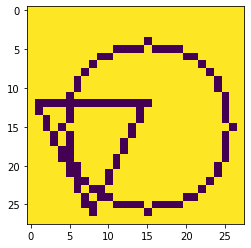

In [ ]:
datum, label = randomcomb_2(shapeset2(10), 4)
plt.imshow(datum[0])
print(label[0])

Shapeset2 is a function that includes blank images. This means that there are already built in singular images in this dataset.

## Multiple Shape Models

#### Forward Euler implementation

Let us quickly redefine the ode_solve function to be forward euler implementation

In [ ]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]      
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)    
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt                  

In [ ]:
class ContinuousNeural3Classifier_Multiples(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeural3Classifier_Multiples, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 5)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_multiples = ContinuousNeural3Classifier_Multiples(ode)
if use_cuda:
    model_multiples = model_multiples.cuda()

The random combination dataset is now structured such that the each immeidate element in the list is a combination of the ..(image, label)..., compared to [(images)(labels)].

In [ ]:

class TensorDataset(Dataset):
    def __init__(self, xyfile ):
        self.xfile, self.yfile = xyfile[:][0], xyfile[:][1]
    def __len__(self):
        return len(self.yfile)

    def __getitem__(self, index):
        # img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # image = torchvision.transforms.functional.to_tensor(self.xfile[index].reshape( 1, 28, 28))
        image = torchvision.transforms.functional.to_tensor(self.xfile[index])
        y_label = torch.tensor(self.yfile[index])

        return (image, y_label)    

In [ ]:
train_dataset = TensorDataset(randomcomb_2(shapeset(2700), 2700))  #Multiply number by 3 compared to previous image datasets to keep training amount similar between models
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
test_dataset = TensorDataset(randomcomb_2(shapeset(6000), 6000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_multiples.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model_multiples.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_multiples(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_multiples.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_multiples(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.433%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.51958
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.967%
Training Epoch 2...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.07994
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 96.067%
Training Epoch 3...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.04906
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 95.900%
Training Epoch 4...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.02480
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 99.717%
Training Epoch 5...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.01191
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 98.783%


##### 1/2

Let's try to consider what happens if we decrease the step-size by 1/2 in our ode_solve algorithm.

In [243]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.025
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]      
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)    
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt                  

In [244]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_multiples_half = ContinuousNeural3Classifier_Multiples(ode)
if use_cuda:
    model_multiples_half = model_multiples_half.cuda()    
train_dataset = TensorDataset(randomcomb_2(shapeset(1350), 1350)) 
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
test_dataset = TensorDataset(randomcomb_2(shapeset(6000), 6000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_multiples_half.parameters())     

def train(epoch):
    num_items = 0
    train_losses = []

    model_multiples_half.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_multiples_half(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_multiples_half.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_multiples_half(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [245]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 34.217%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.98394
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 32.800%
Training Epoch 2...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.28977
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 32.800%
Training Epoch 3...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.14231
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 83.450%
Training Epoch 4...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.07282
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 96.750%
Training Epoch 5...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.04533
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 99.300%


#### Backward Euler Implementation

In [ ]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z+h, t+h)#Backwards euler implementation
        t = t + h
    return z
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]      
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)    
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt                  

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_multiples2 = ContinuousNeural3Classifier_Multiples(ode)
if use_cuda:
    model_multiples2 = model_multiples2.cuda()    
train_dataset = TensorDataset(randomcomb_2(shapeset(2700), 2700)) 
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
test_dataset = TensorDataset(randomcomb_2(shapeset(6000), 6000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_multiples2.parameters())     

def train(epoch):
    num_items = 0
    train_losses = []

    model_multiples2.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_multiples2(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_multiples2.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_multiples2(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.083%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.48334
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 63.317%
Training Epoch 2...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.05916
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 99.367%
Training Epoch 3...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.03057
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 99.650%
Training Epoch 4...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.04746
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 93.600%
Training Epoch 5...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.01742
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 99.567%


##### 1/2

In [246]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.025
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z+h, t+h)#Backwards euler implementation
        t = t + h
    return z
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]      
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)    
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt                  

In [247]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_multiples_half_2 = ContinuousNeural3Classifier_Multiples(ode)
if use_cuda:
    model_multiples_half_2 = model_multiples_half_2.cuda()    
train_dataset = TensorDataset(randomcomb_2(shapeset(1350), 1350)) 
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
test_dataset = TensorDataset(randomcomb_2(shapeset(6000), 6000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_multiples_half_2.parameters())     

def train(epoch):
    num_items = 0
    train_losses = []

    model_multiples_half_2.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_multiples_half_2(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_multiples_half_2.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_multiples_half_2(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [248]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 0.000%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.98963
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.800%
Training Epoch 2...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.28686
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 54.233%
Training Epoch 3...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.14394
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 62.800%
Training Epoch 4...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.10311
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 92.800%
Training Epoch 5...


  0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.07231
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 99.450%


#### Crank Nicolson Implementation

In [ ]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z+h/2, t+h/2)#Backwards euler implementation
        t = t + h
    return z
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]      
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)    
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt                  

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_multiples3 = ContinuousNeural3Classifier_Multiples(ode)
if use_cuda:
    model_multiples3 = model_multiples3.cuda()    
train_dataset = TensorDataset(randomcomb_2(shapeset(2700), 2700)) 
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
test_dataset = TensorDataset(randomcomb_2(shapeset(6000), 6000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_multiples3.parameters())     

def train(epoch):
    num_items = 0
    train_losses = []

    model_multiples3.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_multiples3(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_multiples3.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_multiples3(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.350%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.60026
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 33.917%
Training Epoch 2...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.09490
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 90.000%
Training Epoch 3...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.03648
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 97.667%
Training Epoch 4...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.03411
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 90.133%
Training Epoch 5...


  0%|          | 0/23 [00:00<?, ?it/s]

Train loss: 0.04319
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 97.367%


##### 1/2

In [237]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.025
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z+h/2, t+h/2)#Backwards euler implementation
        t = t + h
    return z
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None    
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]      
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)    
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt                  

In [238]:
func = ConvODEF(64)
ode = NeuralODE(func)
model_multiples_half_3 = ContinuousNeural3Classifier_Multiples(ode)
if use_cuda:
    model_multiples_half_3 = model_multiples_half_3.cuda()    
train_dataset = TensorDataset(randomcomb_2(shapeset(1350), 1350)) 
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=False)
test_dataset = TensorDataset(randomcomb_2(shapeset(6000), 6000)) 
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False) 
train_loader = train_dataloader
test_loader = test_dataloader
optimizer = torch.optim.Adam(model_multiples_half_3.parameters())     

def train(epoch):
    num_items = 0
    train_losses = []

    model_multiples_half_3.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model_multiples_half_3(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses
def test():
    accuracy = 0.0
    num_items = 0

    model_multiples_half_3.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model_multiples_half_3(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [239]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 32.683%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 1.15660
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 26.633%
Training Epoch 2...


  0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.48559
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 32.683%
Training Epoch 3...


  0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.19224
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 46.550%
Training Epoch 4...


  0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.09292
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 54.867%
Training Epoch 5...


  0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.05527
Testing...


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 66.850%
